In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import librosa
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
def getMfcc(wav):
    wav = librosa.util.fix_length(wav, size=17146)
    wav = librosa.effects.preemphasis(y=wav, coef=0.97)

    mfcc = librosa.feature.mfcc(y=wav,
                                sr=16000,
                                n_fft=400,
                                hop_length=160,
                                n_mfcc=40
                                )

    mfcc = mfcc[1:]
        # min_val = np.min(mfcc)
        # max_val = np.max(mfcc)
        # mfcc = (mfcc - min_val) / (max_val - min_val)


        # n_components = 1  # 축소할 차원 수 지정
        # pca = PCA(n_components=n_components)
        # mfcc = pca.fit_transform(mfcc)

        # min_val = np.min(mfcc)
        # max_val = np.max(mfcc)
        # mfcc = (mfcc - min_val) / (max_val - min_val)
    #
    # mfcc = scaler.fit_transform(mfcc)

    return mfcc

In [4]:
# 음성 데이터 폴더 경로
train_data_file = 'fmcc_train.ctl'
test_data_file = 'fmcc_test.ctl'
test_label_file = 'fmcc_test_ref.txt'

# gmm = GaussianMixture(n_components=2, random_state=42, max_iter=10)

In [5]:
X_train = []
X_test = []
test_labels = []

# Train 데이터
with open("data/" + train_data_file, 'r') as file:
    for file_path in file:
        file_path = file_path.rstrip("\n")
        wav, sr = librosa.load("data/wav16k/train/" + file_path + ".wav", sr=16000, mono=True)
        mfcc = getMfcc(wav)
        X_train.append(mfcc)

X_train_array = np.array(X_train)
np.save('X_train_array.npy', X_train_array)

# Test 데이터
with open("data/" + test_data_file, 'r') as file:
    for file_path in file:
        file_path = file_path.rstrip("\n")
        wav, sr = librosa.load("data/wav16k/test/" + file_path + ".wav", sr=16000, mono=True)
        mfcc = getMfcc(wav)
        X_test.append(mfcc)

X_test_array = np.array(X_test)
np.save('X_test_array.npy', X_test)

# Test 데이터의 정답 레이블을 읽어와 저장
with open("data/" + test_label_file, 'r') as file:
    for i, txt in enumerate(file):
        _, labels = txt.rstrip("\n").split()

        if labels == "feml":
            labels = 0
        else: labels = 1

        test_labels.append(labels)

In [6]:
print(X_train_array.shape)
print(X_test_array.shape)

(10000, 39, 108)
(900, 39, 108)


In [7]:
X_train_2d = X_train_array.reshape(X_train_array.shape[0], -1)
X_test_2d = X_test_array.reshape(X_test_array.shape[0], -1)

print(X_train_2d.shape)
print(X_test_2d.shape)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

(10000, 4212)
(900, 4212)


In [8]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(10000, 2)
(900, 2)


In [10]:
train_feml = []
train_male = []

# Train 데이터 남/여 구분
with open("data/" + train_data_file, 'r') as file:
    for file_path in file:
        file_path = file_path.rstrip("\n")
        wav, sr = librosa.load("data/wav16k/train/" + file_path + ".wav", sr=16000, mono=True)
        mfcc = getMfcc(wav)

        if file_path[0] == "F":
            train_feml.append(mfcc)
        else:
            train_male.append(mfcc)

feml = np.array(train_feml)
male = np.array(train_male)

np.save('female.npy', feml)
np.save('male.npy', male)

In [11]:
print(feml.shape)
print(male.shape)

(5000, 39, 108)
(5000, 39, 108)


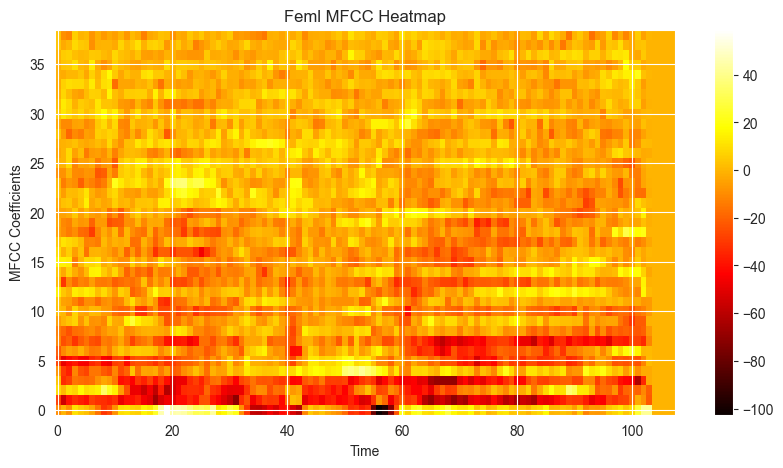

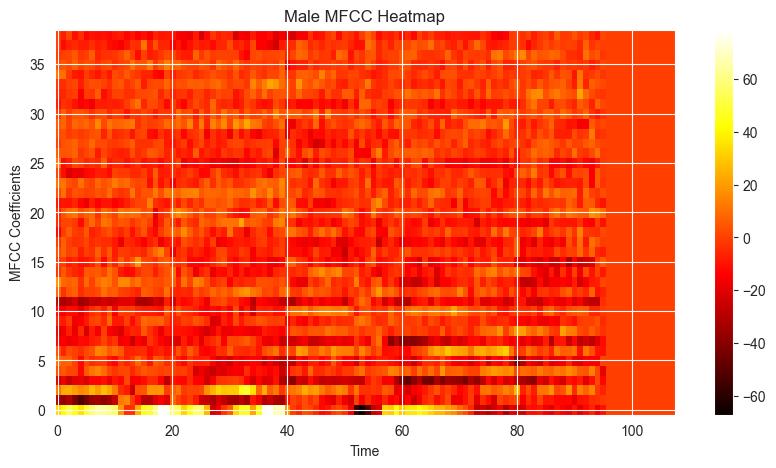

In [22]:
# Feml 히트맵
plt.figure(figsize=(10, 5))
plt.imshow(feml[1], aspect='auto', origin='lower', cmap='hot')
plt.title('Feml MFCC Heatmap')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar()
plt.show()

# Male 히트맵
plt.figure(figsize=(10, 5))
plt.imshow(male[1], aspect='auto', origin='lower', cmap='hot')
plt.title('Male MFCC Heatmap')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar()
plt.show()

In [12]:
f = feml.reshape(feml.shape[0], -1)
m = male.reshape(male.shape[0], -1)

print(f.shape)
print(m.shape)

pca = PCA(n_components=2)
f_pca = pca.fit_transform(f)
m_pca = pca.transform(m)

print(f_pca.shape)
print(m_pca.shape)

(5000, 4212)
(5000, 4212)
(5000, 2)
(5000, 2)


In [15]:
# from sklearn.utils.testing import ignore_warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# 데이터를 NumPy 배열로 변환
# X_train = np.concatenate(X_train, axis=0)
# X_test = np.concatenate(X_test, axis=0)
test_labels = np.array(test_labels)

In [16]:
# GMM 모델 학습
with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        model = GaussianMixture(n_components=2, init_params='random', random_state=0, tol=1e-9, max_iter=20)
        model.fit(X_train_2d)

# Test 데이터셋에 대한 예측
predictions = model.predict(X_test_2d)

# 정답 맞춘 비율 계산
accuracy = np.mean(predictions == test_labels.reshape(-1))
# print(predictions)
# print(test_labels.reshape(-1))

# 결과 출력
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 47.00%
